In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
train=pd.read_csv("Train.csv",parse_dates=["InvoiceDate"])
test=pd.read_csv("Test.csv", parse_dates=["InvoiceDate"])

In [6]:
train.describe()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
count,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000
mean,9955.394083,1573.386807,2023.955573,12.028468,3.451216,15288.224278,32.823846
std,5551.519138,843.604991,1089.812078,295.111588,78.399541,1714.336529,6.743602
min,0.000000,0.000000,0.000000,-80995.000000,0.000000,12346.000000,0.000000
25%,5069.000000,939.000000,1141.000000,2.000000,1.250000,13953.000000,35.000000
50%,10310.000000,1521.000000,1987.000000,5.000000,1.950000,15152.000000,35.000000
75%,14657.000000,2106.000000,2945.000000,12.000000,3.750000,16794.000000,35.000000
max,22188.000000,3683.000000,3895.000000,80995.000000,38970.000000,18287.000000,36.000000


In [7]:
test["UnitPrice"]=-1
data=pd.concat((train,test), axis=0)

In [8]:
data["inv_count"]=data.groupby("InvoiceNo")["StockCode"].transform("count")
data["stock_count"]=data.groupby("StockCode")["InvoiceNo"].transform("count")
data["cust_count"]=data.groupby("CustomerID")["InvoiceNo"].transform("count")
#data["coun_count"]=data.groupby("Country")["InvoiceNo"].transform("count")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,inv_count,stock_count,cust_count
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35,44,491,1128
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098.0,35,42,282,605
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044.0,35,66,475,461
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525.0,35,40,480,180
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952.0,35,44,156,138


In [9]:
train=data[data["UnitPrice"]!=-1]
test=data[data["UnitPrice"]==-1]
test.drop("UnitPrice", axis=1, inplace=True)

In [10]:
train.loc[train["Quantity"]<0,"Quantity"]=train.loc[train["Quantity"]<0,"Quantity"].apply(lambda x:x*-1)
test.loc[test["Quantity"]<0,"Quantity"]=test.loc[test["Quantity"]<0,"Quantity"].apply(lambda x:x*-1)

<AxesSubplot:xlabel='InvoiceDate'>

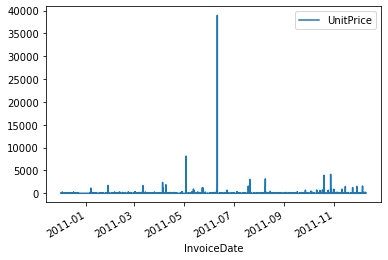

In [11]:
train.plot("InvoiceDate","UnitPrice")

In [12]:
train=train[train["UnitPrice"]<5000]
#train=train[train["UnitPrice"]>0]
train.shape

(284778, 11)

In [13]:
train=train.drop_duplicates()
train.shape

(282157, 11)

In [14]:
ind=np.random.permutation(len(train))
train=train.iloc[ind,]
train=train.reset_index(drop=True)
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,inv_count,stock_count,cust_count
0,2988,1839,3487,1,2011-02-17 14:19:00,0.42,17841.0,35,49,169,7983
1,6380,779,2202,2,2011-05-11 12:44:00,4.95,15079.0,35,19,345,48
2,12136,3147,704,4,2011-09-14 11:36:00,4.15,18065.0,35,28,432,138
3,17383,1355,2241,7,2011-11-27 12:29:00,0.85,15443.0,35,75,204,385
4,15286,2145,3746,12,2011-11-03 11:51:00,2.10,16841.0,35,17,285,117


In [15]:
cust_train=train[["CustomerID","UnitPrice"]].groupby("CustomerID").agg(["mean"])
cust_train.columns=["cust_mean"]
cust_train.head()

,cust_mean
CustomerID,
12346.0,1.040000
12347.0,2.719924
12348.0,7.791364
12349.0,4.231321
12350.0,5.063636


In [16]:
train=pd.merge(train,cust_train,how="left", on=["CustomerID"])
test=pd.merge(test,cust_train,how="left", on=["CustomerID"])
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,inv_count,stock_count,cust_count,cust_mean
0,2988,1839,3487,1,2011-02-17 14:19:00,0.42,17841.0,35,49,169,7983,2.549700
1,6380,779,2202,2,2011-05-11 12:44:00,4.95,15079.0,35,19,345,48,5.134483
2,12136,3147,704,4,2011-09-14 11:36:00,4.15,18065.0,35,28,432,138,3.879286
3,17383,1355,2241,7,2011-11-27 12:29:00,0.85,15443.0,35,75,204,385,3.138168
4,15286,2145,3746,12,2011-11-03 11:51:00,2.10,16841.0,35,17,285,117,1.343373


In [17]:
d_train=train[["InvoiceDate","UnitPrice"]].groupby("InvoiceDate").agg(["mean"])
d_train.columns=["date_mean"]
d_train.head()

,date_mean
InvoiceDate,
2010-12-01 08:26:00,3.996667
2010-12-01 08:28:00,1.850000
2010-12-01 08:34:00,5.052857
2010-12-01 08:35:00,5.950000
2010-12-01 08:45:00,2.699444


In [18]:
train=pd.merge(train,d_train,how="left", on=["InvoiceDate"])
test=pd.merge(test,d_train,how="left", on=["InvoiceDate"])
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,inv_count,stock_count,cust_count,cust_mean,date_mean
0,2988,1839,3487,1,2011-02-17 14:19:00,0.42,17841.0,35,49,169,7983,2.549700,1.676857
1,6380,779,2202,2,2011-05-11 12:44:00,4.95,15079.0,35,19,345,48,5.134483,8.681111
2,12136,3147,704,4,2011-09-14 11:36:00,4.15,18065.0,35,28,432,138,3.879286,3.120000
3,17383,1355,2241,7,2011-11-27 12:29:00,0.85,15443.0,35,75,204,385,3.138168,2.473000
4,15286,2145,3746,12,2011-11-03 11:51:00,2.10,16841.0,35,17,285,117,1.343373,1.013571


In [19]:
inv_train=train[["InvoiceNo","UnitPrice"]].groupby("InvoiceNo").agg(["mean"])
inv_train.columns=["inv_mean"]
inv_train.head()

,inv_mean
InvoiceNo,
0,3.996667
1,1.850000
2,5.164000
3,4.775000
4,5.950000


In [20]:
train=pd.merge(train,inv_train,how="left", on=["InvoiceNo"])
test=pd.merge(test,inv_train,how="left", on=["InvoiceNo"])
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,inv_count,stock_count,cust_count,cust_mean,date_mean,inv_mean
0,2988,1839,3487,1,2011-02-17 14:19:00,0.42,17841.0,35,49,169,7983,2.549700,1.676857,1.664412
1,6380,779,2202,2,2011-05-11 12:44:00,4.95,15079.0,35,19,345,48,5.134483,8.681111,8.681111
2,12136,3147,704,4,2011-09-14 11:36:00,4.15,18065.0,35,28,432,138,3.879286,3.120000,3.189583
3,17383,1355,2241,7,2011-11-27 12:29:00,0.85,15443.0,35,75,204,385,3.138168,2.473000,2.473000
4,15286,2145,3746,12,2011-11-03 11:51:00,2.10,16841.0,35,17,285,117,1.343373,1.013571,1.013571


In [21]:
desc_train=train[["Description","UnitPrice"]].groupby("Description").agg(["mean"])
desc_train.columns=["desc_mean"]
desc_train.head()

,desc_mean
Description,
0,2.289259
1,1.247342
2,1.245096
3,4.133673
5,14.821053


In [22]:
train=pd.merge(train,desc_train,how="left", on=["Description"])
test=pd.merge(test,desc_train,how="left", on=["Description"])
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,inv_count,stock_count,cust_count,cust_mean,date_mean,inv_mean,desc_mean
0,2988,1839,3487,1,2011-02-17 14:19:00,0.42,17841.0,35,49,169,7983,2.549700,1.676857,1.664412,0.419520
1,6380,779,2202,2,2011-05-11 12:44:00,4.95,15079.0,35,19,345,48,5.134483,8.681111,8.681111,4.950444
2,12136,3147,704,4,2011-09-14 11:36:00,4.15,18065.0,35,28,432,138,3.879286,3.120000,3.189583,4.176420
3,17383,1355,2241,7,2011-11-27 12:29:00,0.85,15443.0,35,75,204,385,3.138168,2.473000,2.473000,0.853355
4,15286,2145,3746,12,2011-11-03 11:51:00,2.10,16841.0,35,17,285,117,1.343373,1.013571,1.013571,2.094924


In [23]:
s_train=train[["StockCode","UnitPrice"]].groupby("StockCode").agg(["mean"])
s_train.columns=["stock_mean"]
s_train.head()

,stock_mean
StockCode,
0,0.850000
1,0.422857
2,0.210000
3,0.650000
4,0.420000


In [24]:
train=pd.merge(train,s_train,how="left", on=["StockCode"])
test=pd.merge(test,s_train,how="left", on=["StockCode"])
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,inv_count,stock_count,cust_count,cust_mean,date_mean,inv_mean,desc_mean,stock_mean
0,2988,1839,3487,1,2011-02-17 14:19:00,0.42,17841.0,35,49,169,7983,2.549700,1.676857,1.664412,0.419520,0.419520
1,6380,779,2202,2,2011-05-11 12:44:00,4.95,15079.0,35,19,345,48,5.134483,8.681111,8.681111,4.950444,4.950444
2,12136,3147,704,4,2011-09-14 11:36:00,4.15,18065.0,35,28,432,138,3.879286,3.120000,3.189583,4.176420,4.088864
3,17383,1355,2241,7,2011-11-27 12:29:00,0.85,15443.0,35,75,204,385,3.138168,2.473000,2.473000,0.853355,0.853355
4,15286,2145,3746,12,2011-11-03 11:51:00,2.10,16841.0,35,17,285,117,1.343373,1.013571,1.013571,2.094924,2.094924


In [25]:
train["day"]=train.InvoiceDate.dt.day
train["hour"]=train.InvoiceDate.dt.hour
train["month"]=train.InvoiceDate.dt.month
train["min"]=train.InvoiceDate.dt.minute

In [26]:
test["day"]=test.InvoiceDate.dt.day
test["hour"]=test.InvoiceDate.dt.hour
test["month"]=test.InvoiceDate.dt.month
test["min"]=test.InvoiceDate.dt.minute

In [27]:
train.drop("InvoiceDate", inplace=True, axis=1)
test.drop("InvoiceDate", inplace=True, axis=1)

In [28]:
train.shape, test.shape

((282157, 19), (122049, 18))

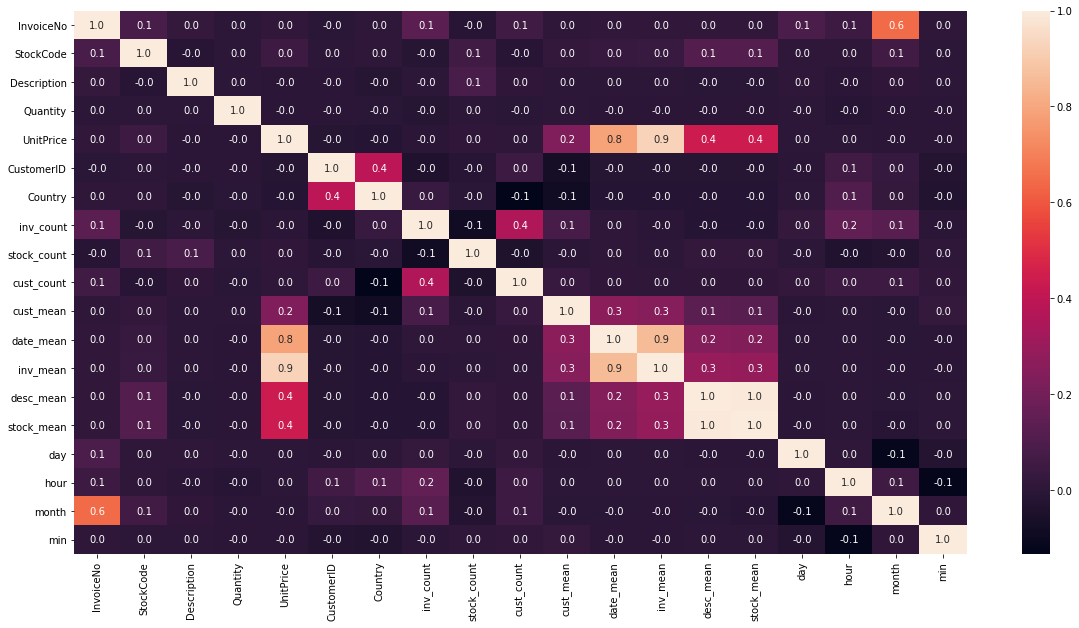

In [29]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(), annot=True, fmt="0.1f");

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282157 entries, 0 to 282156
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    282157 non-null  int64  
 1   StockCode    282157 non-null  int64  
 2   Description  282157 non-null  int64  
 3   Quantity     282157 non-null  int64  
 4   UnitPrice    282157 non-null  float64
 5   CustomerID   282157 non-null  float64
 6   Country      282157 non-null  int64  
 7   inv_count    282157 non-null  int64  
 8   stock_count  282157 non-null  int64  
 9   cust_count   282157 non-null  int64  
 10  cust_mean    282157 non-null  float64
 11  date_mean    282157 non-null  float64
 12  inv_mean     282157 non-null  float64
 13  desc_mean    282157 non-null  float64
 14  stock_mean   282157 non-null  float64
 15  day          282157 non-null  int64  
 16  hour         282157 non-null  int64  
 17  month        282157 non-null  int64  
 18  min          282157 non-

In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    122049 non-null  int64  
 1   StockCode    122049 non-null  int64  
 2   Description  122049 non-null  int64  
 3   Quantity     122049 non-null  int64  
 4   CustomerID   122049 non-null  float64
 5   Country      122049 non-null  int64  
 6   inv_count    122049 non-null  int64  
 7   stock_count  122049 non-null  int64  
 8   cust_count   122049 non-null  int64  
 9   cust_mean    122008 non-null  float64
 10  date_mean    120848 non-null  float64
 11  inv_mean     120608 non-null  float64
 12  desc_mean    121945 non-null  float64
 13  stock_mean   121958 non-null  float64
 14  day          122049 non-null  int64  
 15  hour         122049 non-null  int64  
 16  month        122049 non-null  int64  
 17  min          122049 non-null  int64  
dtypes: float64(6), int64(12)

In [32]:
test["cust_mean"].fillna(np.mean(train.cust_mean), inplace=True)
test["date_mean"].fillna(np.mean(train.date_mean), inplace=True)
test["desc_mean"].fillna(np.mean(train.desc_mean), inplace=True)
test["stock_mean"].fillna(np.mean(train.stock_mean), inplace=True)
test["inv_mean"].fillna(np.mean(train.inv_mean), inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    122049 non-null  int64  
 1   StockCode    122049 non-null  int64  
 2   Description  122049 non-null  int64  
 3   Quantity     122049 non-null  int64  
 4   CustomerID   122049 non-null  float64
 5   Country      122049 non-null  int64  
 6   inv_count    122049 non-null  int64  
 7   stock_count  122049 non-null  int64  
 8   cust_count   122049 non-null  int64  
 9   cust_mean    122049 non-null  float64
 10  date_mean    122049 non-null  float64
 11  inv_mean     122049 non-null  float64
 12  desc_mean    122049 non-null  float64
 13  stock_mean   122049 non-null  float64
 14  day          122049 non-null  int64  
 15  hour         122049 non-null  int64  
 16  month        122049 non-null  int64  
 17  min          122049 non-null  int64  
dtypes: float64(6), int64(12)

In [33]:
train["mean"]=train["desc_mean"]*train["stock_mean"]
test["mean"]=test["desc_mean"]*test["stock_mean"]
train["i_mean"]=train["inv_mean"]*train["date_mean"]
test["i_mean"]=test["inv_mean"]*test["date_mean"]
train.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,inv_count,stock_count,cust_count,...,date_mean,inv_mean,desc_mean,stock_mean,day,hour,month,min,mean,i_mean
0,2988,1839,3487,1,0.42,17841.0,35,49,169,7983,...,1.676857,1.664412,0.419520,0.419520,17,14,2,19,0.175997,2.790981
1,6380,779,2202,2,4.95,15079.0,35,19,345,48,...,8.681111,8.681111,4.950444,4.950444,11,12,5,44,24.506891,75.361690
2,12136,3147,704,4,4.15,18065.0,35,28,432,138,...,3.120000,3.189583,4.176420,4.088864,14,11,9,36,17.076814,9.951500
3,17383,1355,2241,7,0.85,15443.0,35,75,204,385,...,2.473000,2.473000,0.853355,0.853355,27,12,11,29,0.728214,6.115729
4,15286,2145,3746,12,2.10,16841.0,35,17,285,117,...,1.013571,1.013571,2.094924,2.094924,3,11,11,51,4.388706,1.027327


In [34]:
train.drop(["StockCode","InvoiceNo","CustomerID","Description","desc_mean","stock_mean","inv_mean","date_mean"], axis=1, inplace=True)
test.drop(["StockCode","InvoiceNo","CustomerID","Description","desc_mean","stock_mean","inv_mean","date_mean"], axis=1, inplace=True)

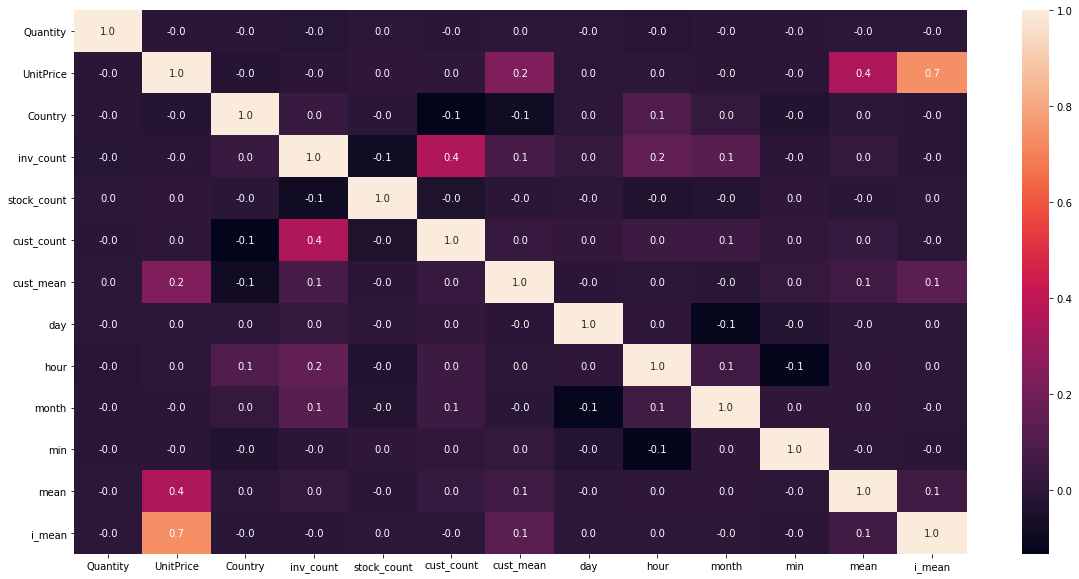

In [35]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(), annot=True, fmt="0.1f");

In [36]:
x=train.drop("UnitPrice",axis=1)
y=train["UnitPrice"]

In [37]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282157 entries, 0 to 282156
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Quantity     282157 non-null  int64  
 1   Country      282157 non-null  int64  
 2   inv_count    282157 non-null  int64  
 3   stock_count  282157 non-null  int64  
 4   cust_count   282157 non-null  int64  
 5   cust_mean    282157 non-null  float64
 6   day          282157 non-null  int64  
 7   hour         282157 non-null  int64  
 8   month        282157 non-null  int64  
 9   min          282157 non-null  int64  
 10  mean         282157 non-null  float64
 11  i_mean       282157 non-null  float64
dtypes: float64(3), int64(9)
memory usage: 28.0 MB


In [38]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33, random_state=123)

In [39]:
rf=RandomForestRegressor(n_jobs=-1)
lgb=LGBMRegressor()

In [40]:
#lgb=LGBMRegressor(max_depth=15,n_estimators=201,learning_rate=0.1,reg_alpha=3,min_child_samples=21,num_leaves=50,min_child_weight=10)
#rf.fit(x_train,y_train)
lgb.fit(x_train,y_train)

LGBMRegressor()

In [41]:
#pr=rf.predict(x_test)
pr=lgb.predict(x_test)

In [42]:
np.sqrt(mean_squared_error(pr,y_test))

18.198923771763884

In [43]:
lgb.score(x_train,y_train)

0.8613449613339852

<AxesSubplot:xlabel='UnitPrice', ylabel='Density'>

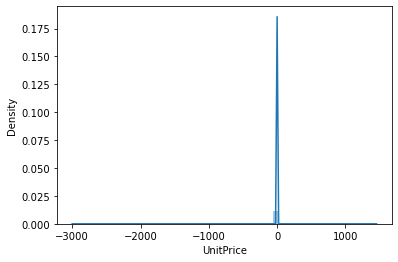

In [44]:
sns.distplot(pr-y_test)

In [45]:
score=cross_val_score(lgb,x,y, cv=5, scoring="neg_mean_squared_error")
np.sqrt(-np.mean(score))

14.403527860069115

In [46]:
lgb=LGBMRegressor()
lgb.fit(x,y)

LGBMRegressor()

In [47]:
pred=lgb.predict(test)

In [48]:
pred=pd.DataFrame(pred, columns=["UnitPrice"])
pred.head()

,UnitPrice
0,1.672014
1,1.256012
2,3.520900
3,1.672014
4,12.429670


In [49]:
pred["UnitPrice"]=np.where(pred["UnitPrice"]<0,np.mean(pred["UnitPrice"]),pred["UnitPrice"])
pred.describe()

,UnitPrice
count,122049.000000
mean,3.068078
std,10.603390
min,0.057926
25%,1.234349
50%,1.922528
75%,3.722255
max,2580.558851


In [50]:
pred.to_csv("submission.csv", index=False)

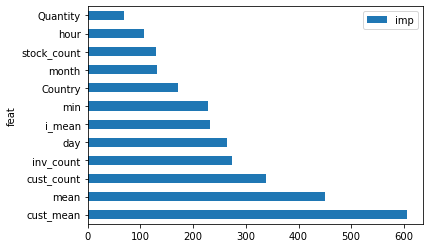

In [51]:
a=zip(x.columns,lgb.feature_importances_)
feat_imp=pd.DataFrame(a)
feat_imp.columns=["feat","imp"]
feat_imp=feat_imp.sort_values(by="imp", ascending=False)
feat_imp.plot("feat","imp","barh");